# Stock price prediction using time series analysis
# Subhashini Natarajan

In [6]:
# Load required libraries

%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARMA, ARIMA
from sklearn.metrics import explained_variance_score
rcParams['figure.figsize'] = 15, 5

In [162]:
# Ingest amazon data from Yahoo finance package

import yfinance as yahooFinance
 
# in order to specify start date and
# end date we need datetime package
import datetime
 
# startDate , as per our convenience we can modify
startDate = datetime.datetime(2021, 1, 1)
 
# endDate , as per our convenience we can modify
endDate = datetime.datetime(2022, 5, 31)
GetAmazonInformation = yahooFinance.Ticker("AMZN")
 
# pass the parameters as the taken dates for start and end
yahoo_data = GetAmazonInformation.history(start=startDate,end=endDate)

yahoo_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-01-04 00:00:00-05:00,163.500000,163.600006,157.201004,159.331497,88228000,0,0
2021-01-05 00:00:00-05:00,158.300507,161.169006,158.253006,160.925507,53110000,0,0
2021-01-06 00:00:00-05:00,157.324005,159.875504,156.557999,156.919006,87896000,0,0
2021-01-07 00:00:00-05:00,157.850006,160.427002,157.750000,158.108002,70290000,0,0
2021-01-08 00:00:00-05:00,159.000000,159.531998,157.110001,159.134995,70754000,0,0
...,...,...,...,...,...,...,...
2022-05-23 00:00:00-04:00,108.460999,108.819000,103.949997,107.556999,107798000,0,0
2022-05-24 00:00:00-04:00,104.025002,105.400002,101.260002,104.099998,102934000,0,0
2022-05-25 00:00:00-04:00,103.655502,108.175003,103.650002,106.775002,93120000,0,0


In [158]:
# Build the data frame with date and closing rate value

dates = pd.date_range(start = '1/1/2021', end ='5/31/2022',freq='B').to_series()
dates.reset_index(inplace=True, drop=True)

values = yahoo_data.Close
values.reset_index(inplace=True, drop=True)

data = pd.concat([dates, values], axis=1)
data.columns = ['Date', 'Close_Adj']

data.dropna(inplace=True)
data.tail(10)

,Date,Close_Adj
325,2022-04-01,110.810501
326,2022-04-04,115.368500
327,2022-04-05,107.112503
328,2022-04-06,107.319000
329,2022-04-07,107.591003
330,2022-04-08,107.556999
331,2022-04-11,104.099998
332,2022-04-12,106.775002
333,2022-04-13,111.077499
334,2022-04-14,115.146500


In [159]:
# Define the threshold to split the data into train and test

from datetime import datetime

date_thresh = datetime.strptime('2021-12-31',"%Y-%m-%d").date()
print(date_thresh)

2021-12-31


In [160]:
# Split the data into train and test

data_train = data[data.Date < date_thresh]
data_test = data[data.Date > date_thresh]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  


Text(0.5, 1.0, 'Amazon Adjusted closing rate - Year 2021')

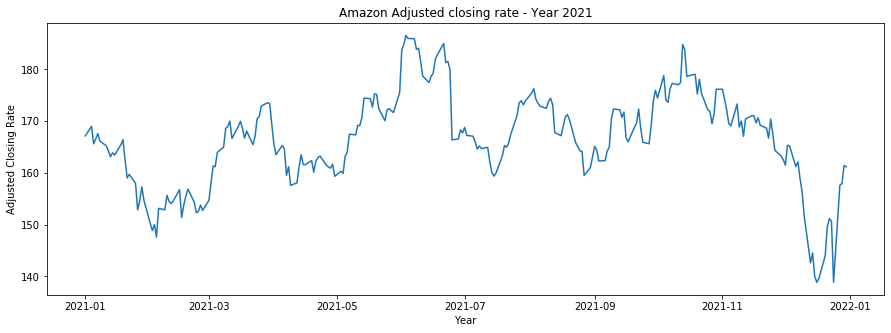

In [164]:
# Plot the closing rate against the date

plt.plot(data_train.Date, data_train['Close_Adj'])
plt.xlabel('Year')
plt.ylabel('Adjusted Closing Rate')
plt.title('Amazon Adjusted closing rate - Year 2021')

In [165]:
# Define function to evaluate the stationary nature of data

def evaluate_stationarity(timeseries, t=30):
   
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=t).mean()
    rolstd = timeseries.rolling(window=t).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
    'p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

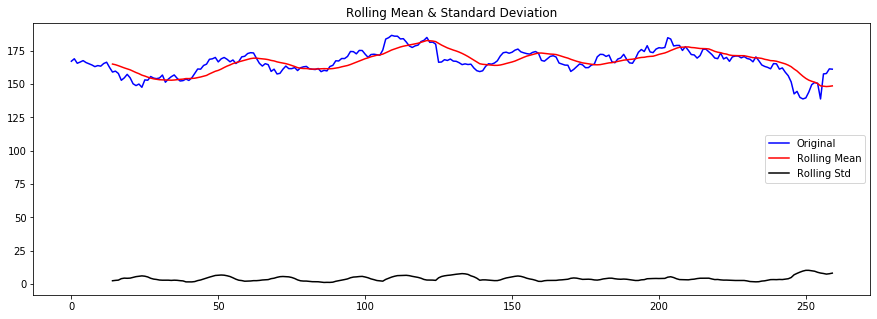

Results of Dickey-Fuller Test:
Test Statistic                  -2.595573
p-value                          0.093916
#Lags Used                       0.000000
Number of Observations Used    259.000000
Critical Value (1%)             -3.455853
Critical Value (5%)             -2.872765
Critical Value (10%)            -2.572752
dtype: float64


In [166]:
evaluate_stationarity(data_train['Close_Adj'], 15)

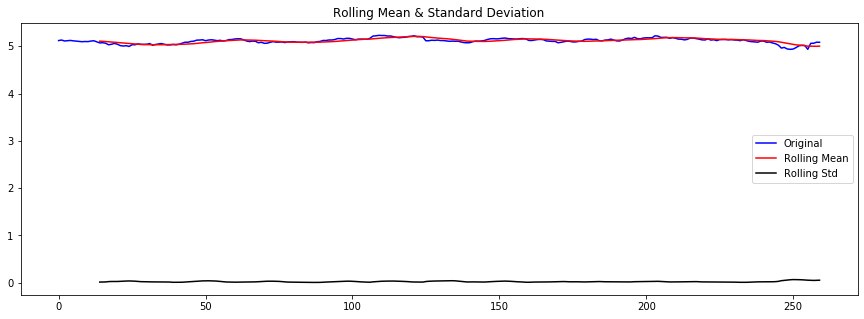

Results of Dickey-Fuller Test:
Test Statistic                  -2.653978
p-value                          0.082346
#Lags Used                       0.000000
Number of Observations Used    259.000000
Critical Value (1%)             -3.455853
Critical Value (5%)             -2.872765
Critical Value (10%)            -2.572752
dtype: float64


In [167]:
# Perform Log transform and evaluate stationary nature

data_log = np.log(data_train['Close_Adj'])
evaluate_stationarity(data_log, 15)

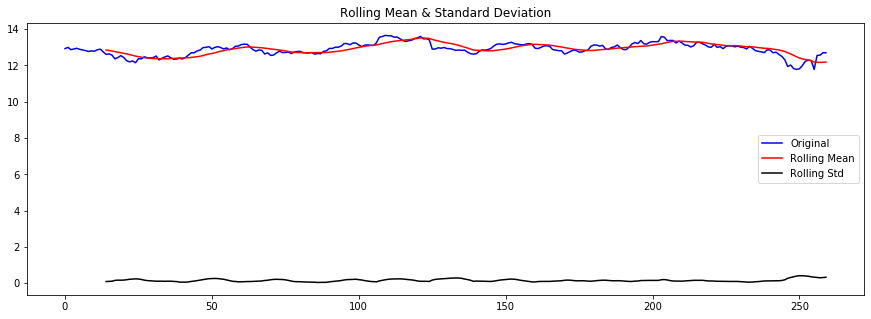

Results of Dickey-Fuller Test:
Test Statistic                  -2.622419
p-value                          0.088452
#Lags Used                       0.000000
Number of Observations Used    259.000000
Critical Value (1%)             -3.455853
Critical Value (5%)             -2.872765
Critical Value (10%)            -2.572752
dtype: float64


In [168]:
# # Perform Square root transformation and evaluate stationary nature 

data_sqrt = np.sqrt(data_train['Close_Adj'])
evaluate_stationarity(data_sqrt, 15)

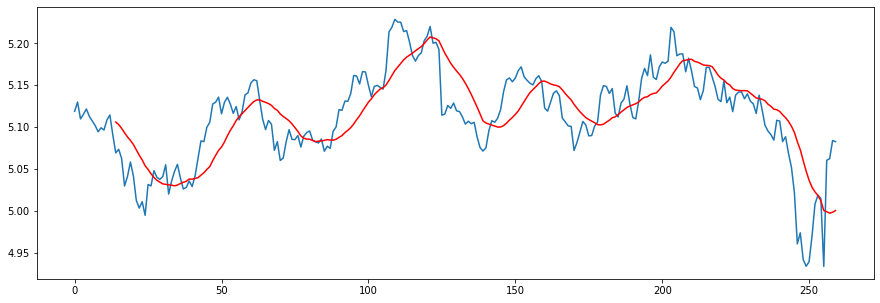

In [169]:
# Peform moving average

moving_avg = data_log.rolling(15).mean()
plt.plot(data_log)
plt.plot(moving_avg, color='red')

In [170]:
# Print moving average data difference

data_log_moving_avg_diff = data_log - moving_avg
data_log_moving_avg_diff.head(15)

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6          NaN
7          NaN
8          NaN
9          NaN
10         NaN
11         NaN
12         NaN
13         NaN
14   -0.036895
Name: Close_Adj, dtype: float64

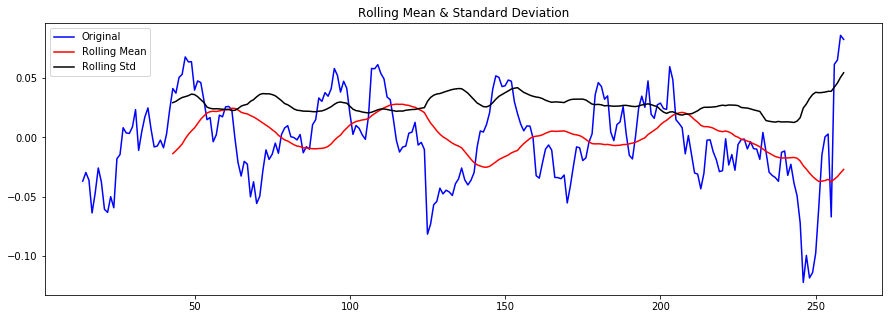

Results of Dickey-Fuller Test:
Test Statistic                  -3.696958
p-value                          0.004156
#Lags Used                       0.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


In [171]:
# Evaluate staionary nature after moving average 

data_log_moving_avg_diff.dropna(inplace=True)
evaluate_stationarity(data_log_moving_avg_diff)

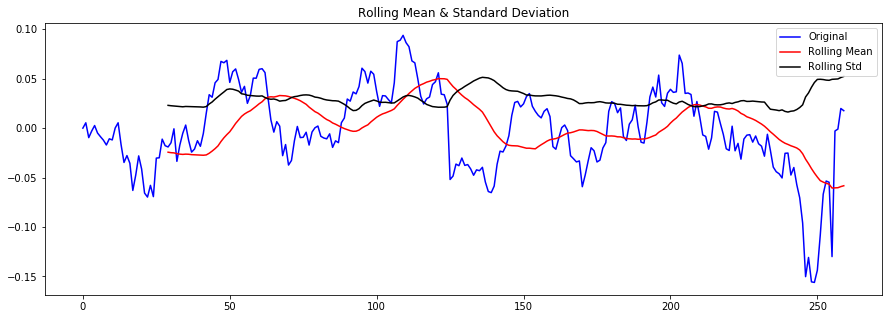

Results of Dickey-Fuller Test:
Test Statistic                  -3.389500
p-value                          0.011322
#Lags Used                       0.000000
Number of Observations Used    259.000000
Critical Value (1%)             -3.455853
Critical Value (5%)             -2.872765
Critical Value (10%)            -2.572752
dtype: float64


In [172]:
# Exponentially weighted moving average

expwighted_avg = data_log.ewm(halflife=15).mean()
data_log_ewma_diff = data_log - expwighted_avg
evaluate_stationarity(data_log_ewma_diff)

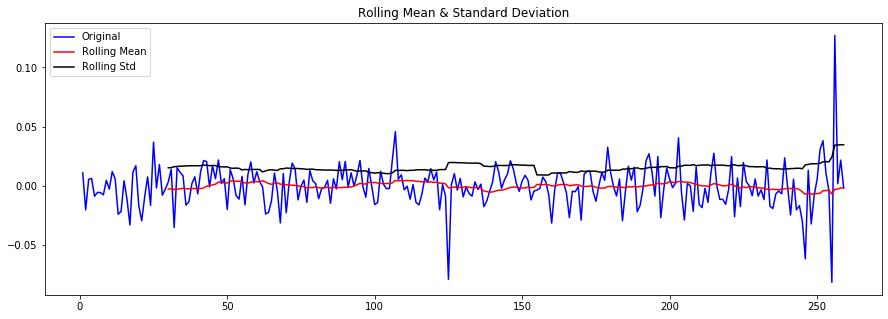

Results of Dickey-Fuller Test:
Test Statistic                -1.674797e+01
p-value                        1.341263e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.580000e+02
Critical Value (1%)           -3.455953e+00
Critical Value (5%)           -2.872809e+00
Critical Value (10%)          -2.572775e+00
dtype: float64


In [173]:
# Differencing


data_log_diff = data_log - data_log.shift()
data_log_diff.dropna(inplace=True)
evaluate_stationarity(data_log_diff)

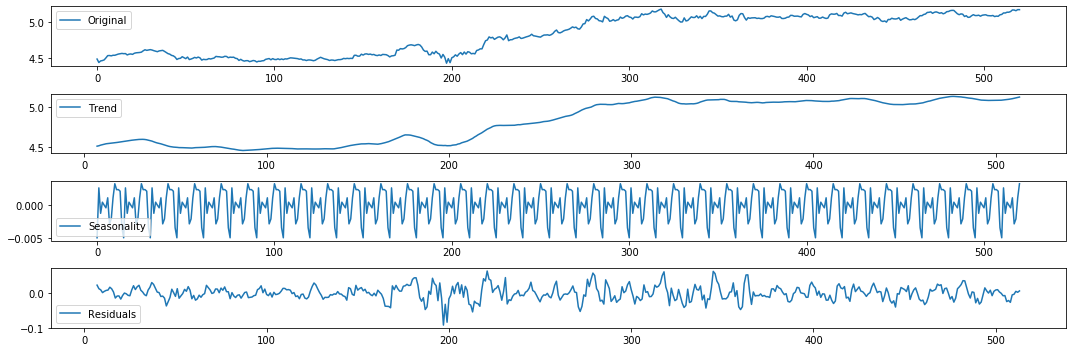

In [126]:
# Decomposition

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(list(data_log), freq=15)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

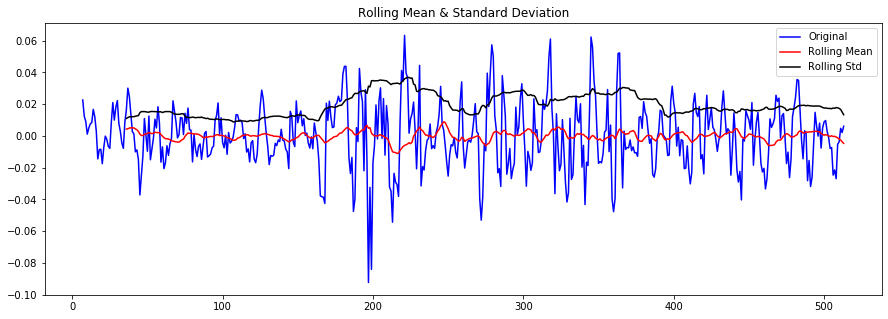

Results of Dickey-Fuller Test:
Test Statistic                -8.956147e+00
p-value                        8.463802e-15
#Lags Used                     1.200000e+01
Number of Observations Used    4.940000e+02
Critical Value (1%)           -3.443657e+00
Critical Value (5%)           -2.867408e+00
Critical Value (10%)          -2.569896e+00
dtype: float64


In [127]:
data_log_decompose = pd.Series(residual)
data_log_decompose.dropna(inplace=True)
evaluate_stationarity(data_log_decompose)

In [174]:
# Verify auto correlation using Durbin Watson Statistic method

sm.stats.durbin_watson(data_log_diff)

2.0882665887617886

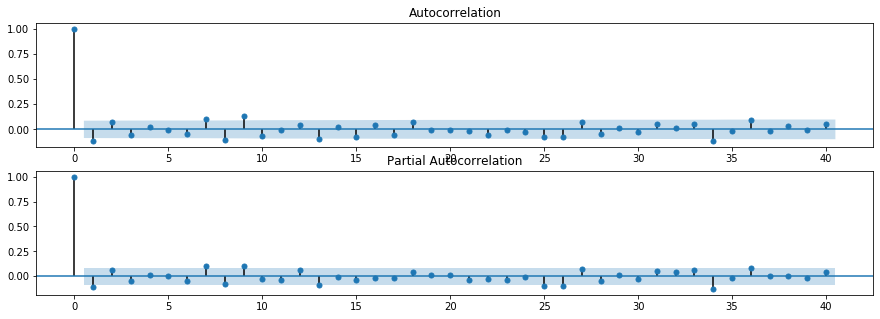

In [129]:
# Plot auto correlation 

ax1 = plt.subplot(211)
fig = sm.graphics.tsa.plot_acf(data_log_diff.squeeze(), lags=40, ax=ax1)

ax2 = plt.subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_log_diff, lags=40, ax=ax2)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/opt/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be

Text(0.5, 1.0, 'RSS: 0.0856')

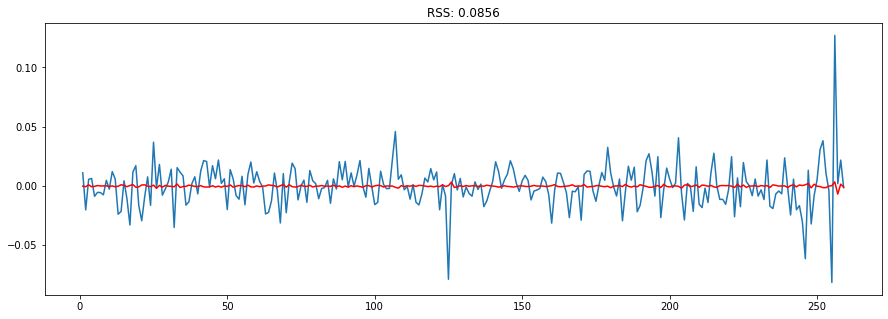

In [175]:
# Build ARIMA model

model = ARIMA(data_log, order=(2, 1, 0), dates=data_train.Date)
results_AR_210 = model.fit(disp=-1)
plt.plot(data_log_diff)
plt.plot(results_AR_210.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR_210.fittedvalues-data_log_diff)**2))

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 0.0854')

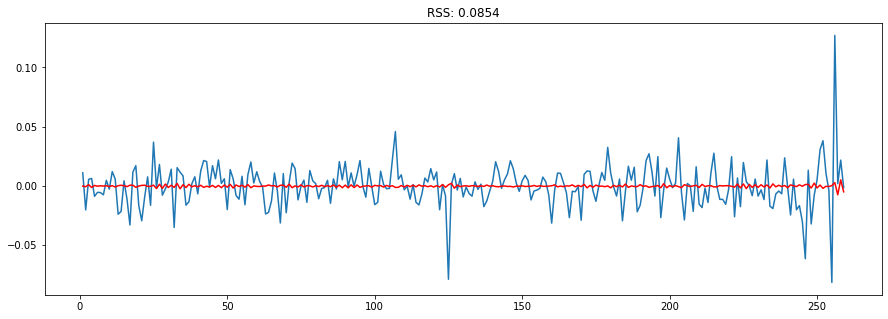

In [176]:
# Plot the model

model = ARIMA(data_log, order=(1, 1, 1), dates=data_train.Date)
results_ARIMA_111 = model.fit(disp=-1)
plt.plot(data_log_diff)
plt.plot(results_ARIMA_111.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA_111.fittedvalues-data_log_diff)**2))

In [177]:
#Forecasted series
predictions_ARIMA_diff = pd.Series(results_ARIMA_111.fittedvalues,copy=True)
print(predictions_ARIMA_diff.head())

1   -0.000135
2   -0.000619
3    0.001062
4   -0.001250
5    0.000423
dtype: float64


In [178]:
#Cumulative sum of forecasted series
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

1   -0.000135
2   -0.000753
3    0.000308
4   -0.000941
5   -0.000518
dtype: float64


In [179]:
#AIC score
print(results_ARIMA_111.aic)

-1333.321121331493


In [180]:
# Differencing removed forecasted series

predictions_ARIMA_log = pd.Series(data_log.ix[0], index=data_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


0    5.118856
1    5.118721
2    5.118102
3    5.119164
4    5.117914
dtype: float64

Text(0.5, 1.0, 'RMSE: 9.8666 | MFE: 2.2453 | MAE: 0.0137')

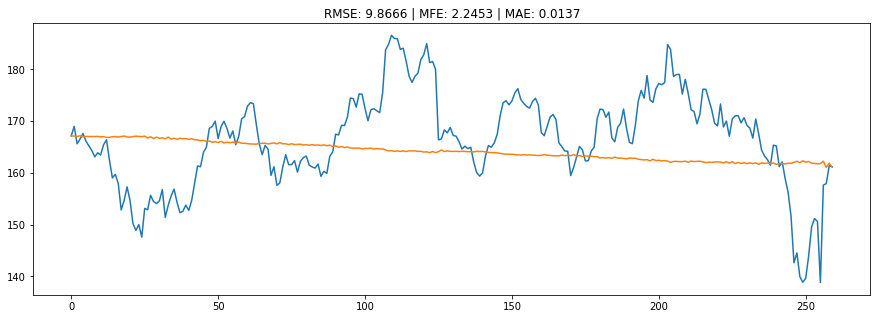

In [184]:
#Forecasted vs Original

def mean_forecast_err(y, yhat):
    return y.sub(yhat).mean()
def mean_absolute_err(y, yhat):
    return np.mean((np.abs(y.sub(yhat).mean()) / yhat)) # or

def rmse(y, yhat):
    return np.sqrt(sum((yhat-y)**2)/len(y))
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data_train['Close_Adj'])
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f | MFE: %.4f | MAE: %.4f'% (rmse(data_train['Close_Adj'], predictions_ARIMA), mean_forecast_err(data_train['Close_Adj'], predictions_ARIMA), mean_absolute_err(data_train['Close_Adj'], predictions_ARIMA)))

Text(0, 0.5, 'Stocks')

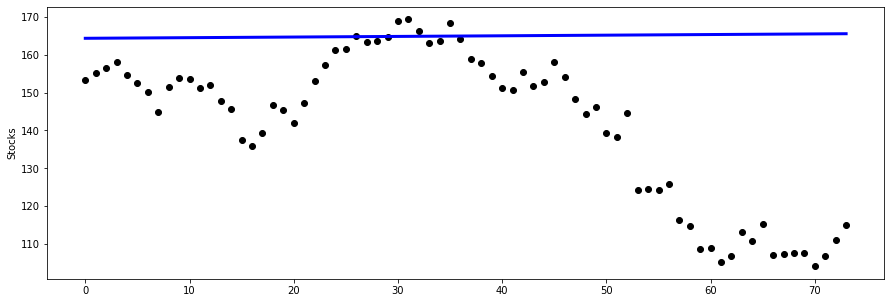

In [182]:
# Applying regression

regr = LinearRegression()

x_train = [[x] for x in range(len(data_train))]
y_train = [[y] for y in list(data_train['Close_Adj'])]


x_test = [[z] for z in range(len(data_test))]

regr.fit(x_train, y_train)

y_pred = regr.predict(x_test)

explained_variance_score(data_test['Close_Adj'], y_pred)
plt.scatter(range(len(data_test)), data_test['Close_Adj'],  color='black')
plt.plot(range(len(data_test)), y_pred, color='blue', linewidth=3)

plt.ylabel('Stocks')


In [188]:
# Define mean absolute percentage error

def mape(y, yhat):
    return np.mean(np.abs(yhat - y)/np.abs(y))

In [190]:
# Obtain Mean Absolute percentage error

mape(data_train['Close_Adj'],predictions_ARIMA)

0.047438918017339245

The error indicates that the model is 95.3% accurate.